<a href="https://colab.research.google.com/github/purbayankar/Hyperspectral-Vision-Transformer/blob/main/HamidaEtAl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral==0.20
!mkdir /content/classification_maps/

     |████████████████████████████████| 153kB 12.3MB/s 
  Created wheel for spectral: filename=spectral-0.20-cp36-none-any.whl size=183918 sha256=d7add731c73cce1a0663eb4a1e8c834a8bcb4294e7cce8280979498e0f3b1965
  Stored in directory: /root/.cache/pip/wheels/ad/cf/f3/3cab28f6aed46f15c8db09c6ad678483610426261025e61ff8
Successfully built spectral


In [ ]:
import numpy as np
import torch
from operator import truediv

def evaluate_accuracy(data_iter, net, model_vit, loss, device):
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            test_l_sum, test_num = 0, 0
            #X = X.permute(0, 3, 1, 2)
            X = X.to(device)
            y = y.to(device)
            net.eval()
            model_vit.eval()
            y_hat = net(X)
            y_hat = model_vit(y_hat)
            l = loss(y_hat, y.long())
            acc_sum += (y_hat.argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            test_l_sum += l
            test_num += 1
            net.train()
            model_vit.train()
            n += y.shape[0]
    return [acc_sum / n, test_l_sum] # / test_num]


def aa_and_each_accuracy(confusion_matrix):
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc



def record_output(oa_ae, aa_ae, kappa_ae, element_acc_ae, training_time_ae, testing_time_ae, confusion_matrix, path):
    f = open(path, 'a')
    sentence0 = 'OAs for each iteration are:' + str(oa_ae) + '\n'
    f.write(sentence0)
    sentence1 = 'AAs for each iteration are:' + str(aa_ae) + '\n'
    f.write(sentence1)
    sentence2 = 'KAPPAs for each iteration are:' + str(kappa_ae) + '\n' + '\n'
    f.write(sentence2)
    sentence3 = 'mean_OA ± std_OA is: ' + str(np.mean(oa_ae)) + ' ± ' + str(np.std(oa_ae)) + '\n'
    f.write(sentence3)
    sentence4 = 'mean_AA ± std_AA is: ' + str(np.mean(aa_ae)) + ' ± ' + str(np.std(aa_ae)) + '\n'
    f.write(sentence4)
    sentence5 = 'mean_KAPPA ± std_KAPPA is: ' + str(np.mean(kappa_ae)) + ' ± ' + str(np.std(kappa_ae)) + '\n' + '\n'
    f.write(sentence5)
    sentence6 = 'Total average Training time is: ' + str(np.sum(training_time_ae)) + '\n'
    f.write(sentence6)
    sentence7 = 'Total average Testing time is: ' + str(np.sum(testing_time_ae)) + '\n' + '\n'
    f.write(sentence7)
    element_mean = np.mean(element_acc_ae, axis=0)
    element_std = np.std(element_acc_ae, axis=0)
    sentence8 = "Mean of all elements in confusion matrix: " + str(element_mean) + '\n'
    f.write(sentence8)
    sentence9 = "Standard deviation of all elements in confusion matrix: " + str(element_std) + '\n'
    f.write(sentence9)
    sentence10 = "The diagonal Confusion matrix: " + '\n' + str(confusion_matrix) + '\n'
    f.write(sentence10)
    f.close()


In [ ]:
import torch
import numpy as np
import torch.utils.data as Data

def index_assignment(index, row, col, pad_length):
    new_assign = {}
    for counter, value in enumerate(index):
        assign_0 = value // col + pad_length
        assign_1 = value % col + pad_length
        new_assign[counter] = [assign_0, assign_1]
    return new_assign

def select_patch(matrix, pos_row, pos_col, ex_len):
    selected_rows = matrix[range(pos_row-ex_len, pos_row+ex_len+1)]
    selected_patch = selected_rows[:, range(pos_col-ex_len, pos_col+ex_len+1)]
    return selected_patch


def select_small_cubic(data_size, data_indices, whole_data, patch_length, padded_data, dimension):
    small_cubic_data = np.zeros((data_size, 2 * patch_length + 1, 2 * patch_length + 1, dimension))
    data_assign = index_assignment(data_indices, whole_data.shape[0], whole_data.shape[1], patch_length)
    for i in range(len(data_assign)):
        small_cubic_data[i] = select_patch(padded_data, data_assign[i][0], data_assign[i][1], patch_length)
    return small_cubic_data


def generate_iter(TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE, total_indices, VAL_SIZE,
                  whole_data, PATCH_LENGTH, padded_data, INPUT_DIMENSION, batch_size, gt):
    gt_all = gt[total_indices] - 1
    y_train = gt[train_indices] - 1
    y_test = gt[test_indices] - 1

    all_data =  select_small_cubic(TOTAL_SIZE, total_indices, whole_data,
                                                      PATCH_LENGTH, padded_data, INPUT_DIMENSION)

    train_data = select_small_cubic(TRAIN_SIZE, train_indices, whole_data,
                                                        PATCH_LENGTH, padded_data, INPUT_DIMENSION)
    print(train_data.shape)
    test_data =  select_small_cubic(TEST_SIZE, test_indices, whole_data,
                                                       PATCH_LENGTH, padded_data, INPUT_DIMENSION)
    x_train = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], INPUT_DIMENSION)
    x_test_all = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], INPUT_DIMENSION)

    x_val = x_test_all[-VAL_SIZE:]
    y_val = y_test[-VAL_SIZE:]

    x_test = x_test_all[:-VAL_SIZE]
    y_test = y_test[:-VAL_SIZE]
    
    x1_tensor_train = torch.from_numpy(x_train).type(torch.FloatTensor).unsqueeze(1)
    y1_tensor_train = torch.from_numpy(y_train).type(torch.FloatTensor)
    torch_dataset_train = Data.TensorDataset(x1_tensor_train, y1_tensor_train)

    x1_tensor_valida = torch.from_numpy(x_val).type(torch.FloatTensor).unsqueeze(1)
    y1_tensor_valida = torch.from_numpy(y_val).type(torch.FloatTensor)
    torch_dataset_valida = Data.TensorDataset(x1_tensor_valida, y1_tensor_valida)

    x1_tensor_test = torch.from_numpy(x_test).type(torch.FloatTensor).unsqueeze(1)
    y1_tensor_test = torch.from_numpy(y_test).type(torch.FloatTensor)
    torch_dataset_test = Data.TensorDataset(x1_tensor_test,y1_tensor_test)

    all_data.reshape(all_data.shape[0], all_data.shape[1], all_data.shape[2], INPUT_DIMENSION)
    all_tensor_data = torch.from_numpy(all_data).type(torch.FloatTensor).unsqueeze(1)
    all_tensor_data_label = torch.from_numpy(gt_all).type(torch.FloatTensor)
    torch_dataset_all = Data.TensorDataset(all_tensor_data, all_tensor_data_label)


    train_iter = Data.DataLoader(
        dataset=torch_dataset_train,  # torch TensorDataset format
        batch_size=batch_size,  # mini batch size
        shuffle=True,  
        num_workers=0, 
    )
    valiada_iter = Data.DataLoader(
        dataset=torch_dataset_valida,  # torch TensorDataset format
        batch_size=batch_size,  # mini batch size
        shuffle=True,  
        num_workers=0, 
    )
    test_iter = Data.DataLoader(
        dataset=torch_dataset_test,  # torch TensorDataset format
        batch_size=batch_size,  # mini batch size
        shuffle=False, 
        num_workers=0, 
    )
    all_iter = Data.DataLoader(
        dataset=torch_dataset_all,  # torch TensorDataset format
        batch_size=batch_size,  # mini batch size
        shuffle=False, 
        num_workers=0, 
    )
    return train_iter, valiada_iter, test_iter, all_iter #, y_test

In [ ]:
import numpy as np
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import torch
import cv2
from operator import truediv
from IPython import display


def sampling(proportion, ground_truth):
    train = {}
    test = {}
    labels_loc = {}
    m = max(ground_truth)
    for i in range(m):
        indexes = [j for j, x in enumerate(ground_truth.ravel().tolist()) if x == i + 1]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        if proportion != 1:
            nb_val = max(int((1 - proportion) * len(indexes)), 3)
        else:
            nb_val = 0
        train[i] = indexes[:nb_val]
        test[i] = indexes[nb_val:]
    train_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, test_indexes



def set_figsize(figsize=(3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize


def classification_map(map, ground_truth, dpi, save_path):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(ground_truth.shape[1] * 2.0 / dpi, ground_truth.shape[0] * 2.0 / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    ax.imshow(map)
    fig.savefig(save_path, dpi=dpi)
    return 0


def list_to_colormap(x_list):
    y = np.zeros((x_list.shape[0], 3))
    for index, item in enumerate(x_list):
        if item == 0:
            y[index] = np.array([255, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([0, 255, 0]) / 255.
        if item == 2:
            y[index] = np.array([0, 0, 255]) / 255.
        if item == 3:
            y[index] = np.array([255, 255, 0]) / 255.
        if item == 4:
            y[index] = np.array([0, 255, 255]) / 255.
        if item == 5:
            y[index] = np.array([255, 0, 255]) / 255.
        if item == 6:
            y[index] = np.array([192, 192, 192]) / 255.
        if item == 7:
            y[index] = np.array([128, 128, 128]) / 255.
        if item == 8:
            y[index] = np.array([128, 0, 0]) / 255.
        if item == 9:
            y[index] = np.array([128, 128, 0]) / 255.
        if item == 10:
            y[index] = np.array([0, 128, 0]) / 255.
        if item == 11:
            y[index] = np.array([128, 0, 128]) / 255.
        if item == 12:
            y[index] = np.array([0, 128, 128]) / 255.
        if item == 13:
            y[index] = np.array([0, 0, 128]) / 255.
        if item == 14:
            y[index] = np.array([255, 165, 0]) / 255.
        if item == 15:
            y[index] = np.array([255, 215, 0]) / 255.
        if item == 16:
            y[index] = np.array([0, 0, 0]) / 255.
        if item == 17:
            y[index] = np.array([215, 255, 0]) / 255.
        if item == 18:
            y[index] = np.array([0, 255, 215]) / 255.
        if item == -1:
            y[index] = np.array([0, 0, 0]) / 255.
    return y



def generate_png(all_iter, net, model_vit, gt_hsi, Dataset, device, total_indices):
    pred_test = []
    for X, y in all_iter:
        #X = X.permute(0, 3, 1, 2)
        X = X.to(device)
        net.eval()
        model_vit.eval()
        y_hat = net(X)
        y_hat = model_vit(y_hat)
        pred_test.extend(y_hat.cpu().argmax(axis=1).detach().numpy())
    gt = gt_hsi.flatten()
    x_label = np.zeros(gt.shape)
    for i in range(len(gt)):
        if gt[i] == 0:
            gt[i] = 17
            x_label[i] = 16
    gt = gt[:] - 1
    x_label[total_indices] = pred_test
    x = np.ravel(x_label)
    y_list = list_to_colormap(x)
    y_gt = list_to_colormap(gt)
    y_re = np.reshape(y_list, (gt_hsi.shape[0], gt_hsi.shape[1], 3))
    gt_re = np.reshape(y_gt, (gt_hsi.shape[0], gt_hsi.shape[1], 3))
    path = '/content/' 
    classification_map(y_re, gt_hsi, 300,
                       path + '/classification_maps/' + Dataset + '_'  +  '.png')
    classification_map(gt_re, gt_hsi, 300,
                       path + '/classification_maps/' + Dataset + '_gt.png')
    print('------Get classification maps successful-------')

# Imports

In [ ]:
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import cv2
from operator import truediv

init_notebook_mode(connected=True)
%matplotlib inline

# Downloading Datasets

In [ ]:
if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

if not (os.path.isfile('/content/Salinas_corrected.mat')):
  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
if not (os.path.isfile('/content/Salinas_gt.mat')):
  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

#if not (os.path.isfile('/content/PaviaU.mat')):
#  !wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
#if not (os.path.isfile('/content/PaviaU_gt.mat')):
#  !wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2021-01-16 21:19:36--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.09MB/s    in 2.7s    

2021-01-16 21:19:39 (2.09 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2021-01-16 21:19:39--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-01-16 21:19:39 (160 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

-

# Data Loading

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for Monte Carlo runs
seeds = [1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341]
ensemble = 1

In [ ]:
global Dataset  # UP,IN,SV
dataset = 'IN' #input('Please input the name of Dataset(IN, UP, SV):')
Dataset = dataset.upper()

In [ ]:
# import Utils,geniter,record

In [ ]:
def load_dataset(Dataset):
    if Dataset == 'IN':
        mat_data = sio.loadmat('/content/Indian_pines_corrected.mat')
        mat_gt = sio.loadmat('/content/Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        K = 200
        TOTAL_SIZE = 10249
        VALIDATION_SPLIT = 0.90
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'UP':
        uPavia = sio.loadmat('/content/PaviaU.mat')
        gt_uPavia = sio.loadmat('/content/PaviaU_gt.mat')
        data_hsi = uPavia['paviaU']
        gt_hsi = gt_uPavia['paviaU_gt']
        K = 15
        TOTAL_SIZE = 42776
        VALIDATION_SPLIT = 0.90
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'SV':
        SV = sio.loadmat('/content/Salinas_corrected.mat')
        gt_SV = sio.loadmat('/content/Salinas_gt.mat')
        data_hsi = SV['salinas_corrected']
        gt_hsi = gt_SV['salinas_gt']
        K = 15
        TOTAL_SIZE = 54129
        VALIDATION_SPLIT = 0.90
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)


    # shapeor=data_hsi.shape
    # data_hsi = data_hsi.reshape(-1,data_hsi.shape[-1])
    # data_hsi = PCA(n_components=K).fit_transform(data_hsi)
    # shapeor = np.array(shapeor)
    # shapeor[-1] = K
    # data_hsi = data_hsi.reshape(shapeor)    


    return data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT


# Pytorch Data Loader Creation

In [ ]:
import math
data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE,VALIDATION_SPLIT = load_dataset(Dataset)
print(data_hsi.shape)
image_x, image_y, BAND = data_hsi.shape
data = data_hsi.reshape(np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]),)
CLASSES_NUM = max(gt)
print('The class numbers of the HSI data is:', CLASSES_NUM)

print('-----Importing Setting Parameters-----')
ITER = 1
PATCH_LENGTH = 4
lr, num_epochs, batch_size = 0.001, 100, 32
loss = torch.nn.CrossEntropyLoss()

img_rows = 2*PATCH_LENGTH+1
img_cols = 2*PATCH_LENGTH+1
img_channels = data_hsi.shape[2]
INPUT_DIMENSION = data_hsi.shape[2]
ALL_SIZE = data_hsi.shape[0] * data_hsi.shape[1]
VAL_SIZE = int(TRAIN_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE


KAPPA = []
OA = []
AA = []
TRAINING_TIME = []
TESTING_TIME = []
ELEMENT_ACC = np.zeros((ITER, CLASSES_NUM))

data = preprocessing.scale(data)
data_ = data.reshape(data_hsi.shape[0], data_hsi.shape[1], data_hsi.shape[2])
whole_data = data_
padded_data = np.lib.pad(whole_data, ((PATCH_LENGTH, PATCH_LENGTH), (PATCH_LENGTH, PATCH_LENGTH), (0, 0)),
                         'constant', constant_values=0)

(145, 145, 200)
The class numbers of the HSI data is: 16
-----Importing Setting Parameters-----


# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

In [ ]:
class Residual(nn.Module):  # pytorch
    def __init__(self, in_channels, out_channels, kernel_size, padding, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding, stride=stride),
            nn.ReLU()
        )
        self.conv2 = nn.Conv3d(out_channels, out_channels,
                               kernel_size=kernel_size, padding=padding,stride=stride)
        if use_1x1conv:
            self.conv3 = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

class SSRN_network(nn.Module):
    def __init__(self, band, classes):
        super(SSRN_network, self).__init__()
        self.name = 'SSRN'
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=24,
                                kernel_size=(1, 1, 7), stride=(1, 1, 2))
        self.batch_norm1 = nn.Sequential(
            nn.BatchNorm3d(24, eps=0.001, momentum=0.1, affine=True),  # 0.1
            nn.ReLU(inplace=True)
        )

        self.res_net1 = Residual(24, 24, (1, 1, 7), (0, 0, 3))
        self.res_net2 = Residual(24, 24, (1, 1, 7), (0, 0, 3))
        self.res_net3 = Residual(24, 24, (3, 3, 1), (1, 1, 0))
        self.res_net4 = Residual(24, 24, (3, 3, 1), (1, 1, 0))

        kernel_3d = math.ceil((band - 6) / 2)

        self.conv2 = nn.Conv3d(in_channels=24, out_channels=128, padding=(0, 0, 0),
                               kernel_size=(1, 1, kernel_3d), stride=(1, 1, 1))
        self.batch_norm2 = nn.Sequential(
            nn.BatchNorm3d(128, eps=0.001, momentum=0.1, affine=True),  # 0.1
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Conv3d(in_channels=1, out_channels=24, padding=(0, 0, 0),
                               kernel_size=(3, 3, 128), stride=(1, 1, 1))
        self.batch_norm3 = nn.Sequential(
            nn.BatchNorm3d(24, eps=0.001, momentum=0.1, affine=True),  # 0.1
            nn.ReLU(inplace=True)
        )

        self.avg_pooling = nn.AvgPool3d(kernel_size=(5, 5, 1))
        self.full_connection = nn.Sequential(
            # nn.Dropout(p=0.5),
            nn.Linear(24, classes)  # ,
            # nn.Softmax()
        )

    def forward(self, X):
        x1 = self.batch_norm1(self.conv1(X))
        # print('x1', x1.shape)

        x2 = self.res_net3(x1)
        x2 = self.res_net4(x2)
        x2 = self.batch_norm2(self.conv2(x2))
        x2 = x2.permute(0, 4, 2, 3, 1)
        x2 = self.batch_norm3(self.conv3(x2))

        x2 = x2.view(x2.size()[0],x2.size()[1]*x2.size()[4],x2.size()[2],x2.size()[3])

        return x2

In [ ]:
model = SSRN_network(200, 16).cuda()

In [ ]:
from torchsummary import summary
summary(model, (1,9,9,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [-1, 24, 9, 9, 97]             192
       BatchNorm3d-2         [-1, 24, 9, 9, 97]              48
              ReLU-3         [-1, 24, 9, 9, 97]               0
            Conv3d-4         [-1, 24, 9, 9, 97]           5,208
              ReLU-5         [-1, 24, 9, 9, 97]               0
       BatchNorm3d-6         [-1, 24, 9, 9, 97]              48
            Conv3d-7         [-1, 24, 9, 9, 97]           5,208
       BatchNorm3d-8         [-1, 24, 9, 9, 97]              48
          Residual-9         [-1, 24, 9, 9, 97]               0
           Conv3d-10         [-1, 24, 9, 9, 97]           5,208
             ReLU-11         [-1, 24, 9, 9, 97]               0
      BatchNorm3d-12         [-1, 24, 9, 9, 97]              48
           Conv3d-13         [-1, 24, 9, 9, 97]           5,208
      BatchNorm3d-14         [-1, 24, 9

In [ ]:
!pip install einops
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from torch import nn

MIN_NUM_PATCHES = 16

class Residual_1(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual_1(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual_1(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x, mask = None):
        for attn, ff in self.layers:
            x = attn(x, mask = mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert num_patches > MIN_NUM_PATCHES, f'your number of patches ({num_patches}) is way too small for attention to be effective (at least 16). Try decreasing your patch size'

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, mask = None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        
        return self.mlp_head(x)


In [ ]:
model_vit = ViT(
    image_size = 7,
    patch_size = 1,
    num_classes = 16,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    channels = 24,
    dropout = 0.1,
    emb_dropout = 0.1
).cuda()

# Plotting

In [ ]:
from IPython import display
def train(net, model_vit, train_iter, valida_iter, loss, optimizer, device, epochs, early_stopping=True,
          early_num=20):
    loss_list = [100]
    early_epoch = 0

    net = net.to(device)
    print("training on ", device)
    start = time.time()
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    for epoch in range(epochs):
        train_acc_sum, n = 0.0, 0
        time_epoch = time.time()
        lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)
        for X, y in train_iter:
            
            batch_count, train_l_sum = 0, 0
            #X = X.permute(0, 3, 1, 2)
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            y_hat = model_vit(y_hat)
            # print('y_hat:', y_hat.shape)
            # print('y:', y.shape)
            l = loss(y_hat, y.long())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        lr_adjust.step(epoch)
        valida_acc, valida_loss = evaluate_accuracy(valida_iter, net, model_vit, loss, device)
        loss_list.append(valida_loss)

        
        train_loss_list.append(train_l_sum) # / batch_count)
        train_acc_list.append(train_acc_sum / n)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

        print('epoch %d, train loss %.6f, train acc %.3f, valida loss %.6f, valida acc %.3f, time %.1f sec'
                % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, valida_loss, valida_acc, time.time() - time_epoch))

        PATH = "./net_DBA.pt"
        # if loss_list[-1] <= 0.01 and valida_acc >= 0.95:
        #     torch.save(net.state_dict(), PATH)
        #     break

        if early_stopping and loss_list[-2] < loss_list[-1]:  # < 0.05) and (loss_list[-1] <= 0.05):
            if early_epoch == 0: # and valida_acc > 0.9:
                torch.save(net.state_dict(), PATH)
            early_epoch += 1
            loss_list[-1] = loss_list[-2]
            if early_epoch == early_num:
                net.load_state_dict(torch.load(PATH))
                break
        else:
            early_epoch = 0

    
    set_figsize()
    plt.figure(figsize=(8, 8.5))
    train_accuracy =   plt.subplot(221)
    train_accuracy.set_title('train_accuracy')
    plt.plot(np.linspace(1, epoch, len(train_acc_list)), train_acc_list, color='green')
    plt.xlabel('epoch')
    plt.ylabel('train_accuracy')
    
    test_accuracy =   plt.subplot(222)
    test_accuracy.set_title('valida_accuracy')
    plt.plot(np.linspace(1, epoch, len(valida_acc_list)), valida_acc_list, color='deepskyblue')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')

    loss_sum =   plt.subplot(223)
    loss_sum.set_title('train_loss')
    plt.plot(np.linspace(1, epoch, len(train_loss_list)), train_loss_list, color='red')
    plt.xlabel('epoch')
    plt.ylabel('train loss')
    # ls_plot = np.array(ls_plot)

    test_loss =   plt.subplot(224)
    test_loss.set_title('valida_loss')
    plt.plot(np.linspace(1, epoch, len(valida_loss_list)), valida_loss_list, color='gold')
    plt.xlabel('epoch')
    plt.ylabel('valida loss')
    # ls_plot = np.array(ls_plot)

    plt.show()
    print('epoch %d, loss %.4f, train acc %.3f, time %.1f sec'
            % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, time.time() - start))


In [ ]:
def sampling(proportion, ground_truth):
    train = {}
    test = {}
    labels_loc = {}
    m = max(ground_truth)
    for i in range(m):
        indexes = [j for j, x in enumerate(ground_truth.ravel().tolist()) if x == i + 1]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        if proportion != 1:
            nb_val = max(int((1 - proportion) * len(indexes)), 3)
        else:
            nb_val = 0
        train[i] = indexes[:nb_val]
        test[i] = indexes[nb_val:]
    train_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, test_indexes


# Training

In [ ]:
!pip install torch-optimizer

     |████████████████████████████████| 81kB 6.3MB/s 


In [ ]:
import torch_optimizer as optim2

iter: 0
Train size:  1018
Test size:  9231
Validation size:  1018
-----Selecting Small Pieces from the Original Cube Data-----
(1018, 9, 9, 200)
training on  cuda


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



epoch 1, train loss 1.544114, train acc 0.280, valida loss 2.221943, valida acc 0.390, time 24.8 sec
epoch 2, train loss 1.626118, train acc 0.399, valida loss 1.560249, valida acc 0.427, time 24.7 sec
epoch 3, train loss 2.177094, train acc 0.430, valida loss 1.373191, valida acc 0.531, time 24.7 sec
epoch 4, train loss 1.413411, train acc 0.490, valida loss 2.130903, valida acc 0.411, time 24.7 sec
epoch 5, train loss 1.551359, train acc 0.535, valida loss 0.609110, valida acc 0.534, time 24.7 sec
epoch 6, train loss 1.424841, train acc 0.586, valida loss 1.451720, valida acc 0.453, time 24.7 sec
epoch 7, train loss 2.833993, train acc 0.572, valida loss 1.085356, valida acc 0.534, time 24.7 sec
epoch 8, train loss 1.068065, train acc 0.641, valida loss 0.833933, valida acc 0.630, time 24.7 sec
epoch 9, train loss 0.730443, train acc 0.677, valida loss 1.321851, valida acc 0.681, time 24.7 sec
epoch 10, train loss 0.897029, train acc 0.714, valida loss 1.402109, valida acc 0.728, tim

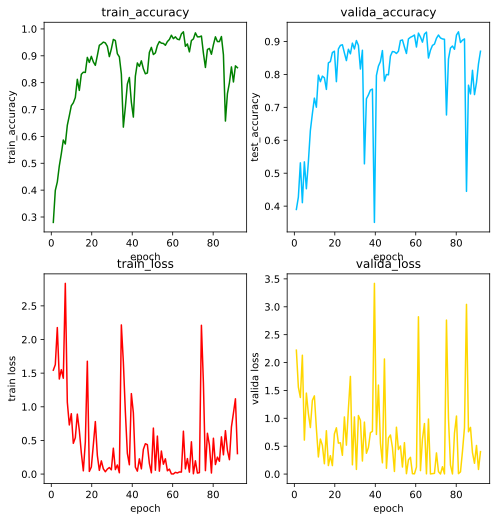

epoch 93, loss 0.3045, train acc 0.856, time 2318.8 sec


In [ ]:
import time
import collections
from torch import optim
for index_iter in range(ITER):
    print('iter:', index_iter)
    #define the model
    #net = pResNet(32, 48, CLASSES_NUM, BAND, 2, 16, bottleneck=True)
    #net = resnet20(num_classes=CLASSES_NUM)
    net = SSRN_network(BAND, CLASSES_NUM)

    #optimizer = optim2.DiffGrad(net.parameters(), lr=lr, amsgrad=False) #, weight_decay=0.0001)
    optimizer = torch.optim.Adam(list(net.parameters())+list(model_vit.parameters()), lr= 1e-3, betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0)
    time_1 = int(time.time())
    np.random.seed(seeds[index_iter])
    train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)
    _, total_indices = sampling(1, gt)

    TRAIN_SIZE = len(train_indices)
    print('Train size: ', TRAIN_SIZE)
    TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE
    print('Test size: ', TEST_SIZE)
    VAL_SIZE = int(TRAIN_SIZE)
    print('Validation size: ', VAL_SIZE)

    print('-----Selecting Small Pieces from the Original Cube Data-----')
    train_iter, valida_iter, test_iter, all_iter = generate_iter(TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE, total_indices, VAL_SIZE,whole_data, PATCH_LENGTH, padded_data, INPUT_DIMENSION, 16, gt) #batchsize in 1

    tic1 = time.clock()
    train(net, model_vit, train_iter, valida_iter, loss, optimizer, device, epochs=100)
    toc1 = time.clock()

    pred_test = []
    tic2 = time.clock()
    with torch.no_grad():
        for X, y in test_iter:
            #X = X.permute(0, 3, 1, 2)
            X = X.to(device)
            net.eval()
            model_vit.eval()
            y_hat = net(X)
            y_hat = model_vit(y_hat)
            pred_test.extend(np.array(y_hat.cpu().argmax(axis=1)))
    toc2 = time.clock()
    collections.Counter(pred_test)
    gt_test = gt[test_indices] - 1


    overall_acc = metrics.accuracy_score(pred_test, gt_test[:-VAL_SIZE])
    confusion_matrix = metrics.confusion_matrix(pred_test, gt_test[:-VAL_SIZE])
    each_acc, average_acc = aa_and_each_accuracy(confusion_matrix)
    kappa = metrics.cohen_kappa_score(pred_test, gt_test[:-VAL_SIZE])

    torch.save(net.state_dict(), "/content/" + str(round(overall_acc, 3)) + '.pt')
    KAPPA.append(kappa)
    OA.append(overall_acc)
    AA.append(average_acc)
    TRAINING_TIME.append(toc1 - tic1)
    TESTING_TIME.append(toc2 - tic2)
    ELEMENT_ACC[index_iter, :] = each_acc



# Map, Records

In [ ]:
print("--------" + " Training Finished-----------")
record_output(OA, AA, KAPPA, ELEMENT_ACC, TRAINING_TIME, TESTING_TIME,confusion_matrix,
                     '/content/'  + str(img_rows) + '_' + Dataset + 'split：' + str(VALIDATION_SPLIT) + 'lr：' + str(lr) + '.txt')


generate_png(all_iter, net, model_vit, gt_hsi, Dataset, device, total_indices)
